# TSP Estimations for UAV in Hostile Environment

In [1]:
from random import seed
from random import randint
from tqdm import tqdm
from shapely.geometry import Point, Polygon
from typing import List, Dict, Union, Tuple
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import time
import math
import os
from heapq import nsmallest
from shapely.geometry import Point, Polygon, LineString

In [14]:
class Environment:
    def __init__(self, num_targets=10, num_no_entrances=10, num_threats=5, x_range=10_000, y_range=10_000,
                 seed_value=42) -> None:
        self._seed_value = seed_value
        seed(self._seed_value)

        # dimensions
        self._x_range = x_range
        self._y_range = y_range

        # entities and targets
        self._no_entrances = self._create_entities(num_no_entrances, (self._x_range / 100, self._x_range / 10))
        self._no_entrances_shapes = [ne['shape'] for ne in self._no_entrances]

        self._threats = self._create_entities(num_threats, (self._x_range / 10, self._x_range / 5))
        self._threats_shapes = [threat['shape'] for threat in self._threats]

        self._targets = self._create_targets(num_targets)
        self._targets_names = [f'({target.x},{target.y})' for target in self._targets]

    @property
    def x_range(self) -> int:
        return self._x_range

    @property
    def y_range(self) -> int:
        return self._y_range

    @property
    def no_entrances(self) -> List[Dict[str, Union[Point, float, Polygon]]]:
        return self._no_entrances

    @property
    def no_entrances_shapes(self) -> List[Polygon]:
        return self._no_entrances_shapes

    @property
    def threats(self) -> List[Dict[str, Union[Point, float, Polygon]]]:
        return self._threats

    @property
    def threats_shapes(self) -> List[Polygon]:
        return self._threats_shapes

    @property
    def targets(self) -> List[Point]:
        return self._targets

    @property
    def targets_names(self) -> List[str]:
        return self._targets_names

    def is_legal_point(self, point: Point) -> bool:
        for obstacle in self._no_entrances:
            if obstacle['shape'].contains(point):
                return False
        return True

    def is_legal_edge(self, p1: Point, p2: Point) -> bool:
        line = LineString([p1, p2])
        for ne in self._no_entrances_shapes:
            if line.intersects(ne):
                return False
        return True

    def _create_entities(self, num_entities: int, radius_range: Tuple[float, float])
        -> List[Dict[str, Union[Point, float, Polygon]]]:

    entities_points = [Point(randint(0, self._x_range), randint(0, self._y_range))
                       for _ in range(num_entities)]

    rads = [randint(*radius_range) for _ in entities_points]

    return [{'center': point, 'radius': radius, 'shape': point.buffer(radius)}
            for point, radius in zip(entities_points, rads)]


def _create_targets(self, num_targets: int) -> List[Point]:
    # create targets out of no entrance zones
    targets = []
    while len(targets) < num_targets:
        potential_target = Point(randint(0, self._x_range), randint(0, self._y_range))
        if self.is_legal_point(potential_target):
            targets.append(potential_target)
    return targets


def sample(self) -> Point:
    rand_point = Point(randint(0, self._x_range), randint(0, self._y_range))
    while not self.is_legal_point(rand_point):
        rand_point = Point(randint(0, self._x_range), randint(0, self._y_range))
    return rand_point


def plot(self) -> None:
    plt.figure(figsize=(10, 10))
    plt.title(f'environment of seed {self._seed_value}', fontsize=20)

    # plot no entrances
    for ne in self._no_entrances:
        X, Y = ne['shape'].exterior.xy
        plt.scatter(ne['center'].x, ne['center'].y, s=30, color='black', zorder=3)
        plt.scatter(ne['center'].x, ne['center'].y, s=20, color='blue', zorder=4)
        plt.plot(X, Y, color='blue')

    # plot threats
    for threat in self._threats:
        X, Y = threat['shape'].exterior.xy
        plt.scatter(threat['center'].x, threat['center'].y, s=30, color='black', zorder=3)
        plt.scatter(threat['center'].x, threat['center'].y, s=20, color='red', zorder=4)
        plt.plot(X, Y, color='red')

    # plot targets
    for target in self._targets:
        plt.scatter(target.x, target.y, color='black', zorder=9, s=100)
        plt.scatter(target.x, target.y, color='gold', zorder=10, s=80)

    # plot legend
    plt.legend(handles=[mpatches.Patch(color='gold', label=f'{len(self._targets)} targets'),
                        mpatches.Patch(color='blue', label=f'{len(self._no_entrances)} no entrance zones'),
                        mpatches.Patch(color='red', label=f'{len(self._threats)} threats')], ncol=3,
               loc='upper center')

In [24]:
class PRM:
    def __init__(self, env: Environment) -> None:
        self._env = env

        # neighborhood consts
        self._neighborhood_k = 10
        self._neighborhood_dist = 1000

        # init graph
        self._graph = nx.Graph()
        self._add_points(env.targets, is_target=True)

    @property
    def graph(self) -> nx.Graph():
        return self._graph

    def _add_points(self, points: List[Point], is_target: bool = False) -> None:
        for point in points:
            self._graph.add_node(f'({point.x},{point.y})', x=point.x, y=point.y, is_target=is_target)

    def _k_neighborhood(self, point: Point) -> List[Tuple[str, Dict]]:
        def _k_nearest_key(point_xy) -> float:
            _, xy = point_xy
            dist = (xy['x'] - point.x) ** 2 + (xy['y'] - point.y) ** 2
            return dist if dist > 0 else math.inf

        k_nearest_nodes = nsmallest(self._neighborhood_k, self._graph.nodes(data=True), key=_k_nearest_key)
        return k_nearest_nodes

    def _dist_neighborhood(self, point: Point) -> List[Tuple[str, Dict]]:
        neighborhood_nodes = []
        for node_name, xy in self._graph.nodes(data=True):
            dist = ((xy['x'] - point.x) ** 2 + (xy['y'] - point.y) ** 2) ** 0.5
            if dist < self._neighborhood_dist:
                neighborhood_nodes.append((node_name, xy))

        return neighborhood_nodes

    def add_samples(self, num_samples: int, neighborhood_type: str = 'k') -> None:
        samples = [self._env.sample() for _ in range(num_samples)]

        # add nodes to graph
        self._add_points(samples)

        # add legal edges to graph
        for sample in samples:
            self._perform_connections(sample, neighborhood_type)

    def _perform_connections(self, sample: Point, neighborhood_type: str) -> None:
        # add sample to graph
        sample_name = f'({sample.x},{sample.y})'
        self._graph.add_node(sample_name, x=sample.x, y=sample.y)

        # find near nodes to connect
        if neighborhood_type == 'k':
            near_nodes = self._k_neighborhood(sample)
        else:
            near_nodes = self._dist_neighborhood(sample)

        # add illegal edges with near group
        for node_name, node_data in near_nodes:
            x1, y1, x2, y2 = sample.x, sample.y, node_data['x'], node_data['y']
            if self._env.is_legal_edge(sample, Point(x2, y2)):
                weight = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
                self._graph.add_edge(sample_name, node_name, x1=x1, x2=x2, y1=y1, y2=y2, weight=weight)

    def plot(self) -> None:
        # plot environment
        self._env.plot()

        # plot roadmap
        plt.title(f'roadmap with {len(self._graph.nodes)} nodes and {len(self._graph.edges)} edges', fontsize=20)

        if self._graph is not None:
            # plot edges
            for _, _, e_data in self._graph.edges(data=True):
                x1, x2, y1, y2 = e_data['x1'], e_data['x2'], e_data['y1'], e_data['y2']
                plt.plot([x1, x2], [y1, y2], color='green')

            # plot nodes
            for _, n_data in self._graph.nodes(data=True):
                x, y = n_data['x'], n_data['y']
                plt.scatter(x, y, color='black', s=60, zorder=7)
                plt.scatter(x, y, color='gray', s=50, zorder=8)

## environment and roadmap examples

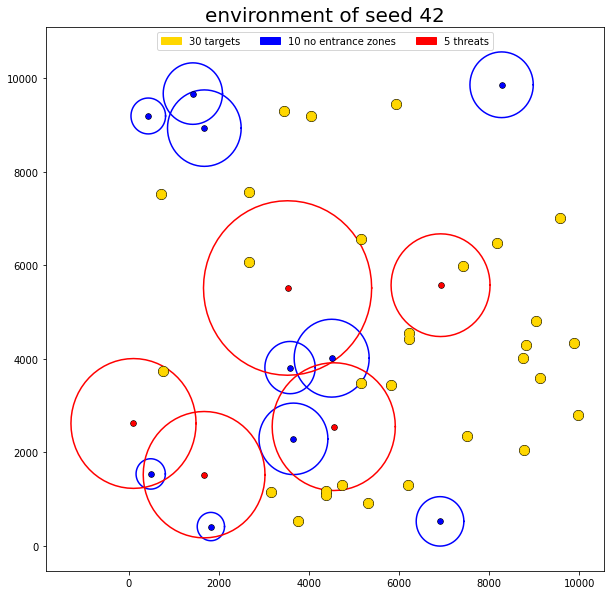

In [25]:
env = Environment(num_targets=30)
env.plot()

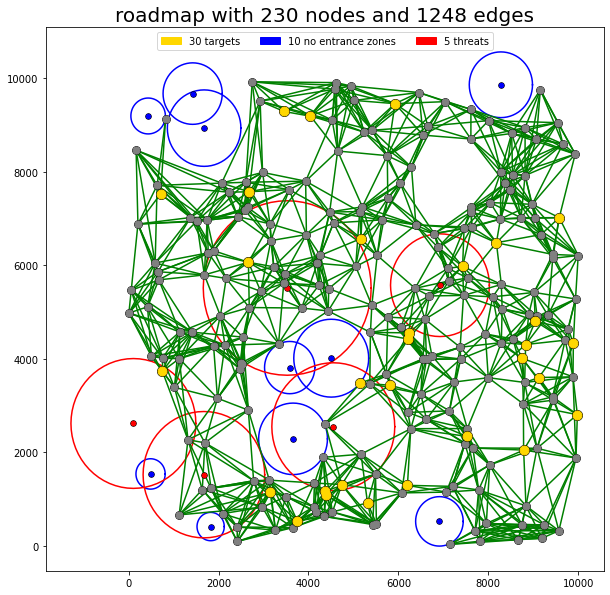

In [27]:
prm = PRM(env)
prm.add_samples(200, neighborhood_type='k')
prm.plot()
plt.show()

## compare tsp distances computation

In [2]:
single_source_times = []
all_source_times = []
nodes_amounts = list(range(100, 2100, 100))
file_name = 'distances_times.txt'

In [3]:
def write_distances_times(file_name: str, seed: float, num_nodes: int, num_edges: int, num_obstacles: int,
                          num_threats: int, num_targets: int, k: int, algorithm: str, computation_time: float) -> None:
    stats = [seed, num_nodes, num_edges, num_obstacles, num_threats, num_targets, k, algorithm, computation_time]
    file = open(file_name, 'a+')
    if not os.path.exists(file_name):
        file.write('seed,num_nodes,num_edges,num_obstacles,num_threats,num_targets,k,algorithm,computation_time')
    else:
        file = open(file_name, '')
    file.write(",".join([str(s) for s in stats]))
    file.write('\n')

In [30]:
for nodes_amount in nodes_amounts:
    env = Environment(num_targets=100)
    prm = PRM(env)
    prm.add_samples(nodes_amount, neighborhood_type='k')
    graph = prm.graph
    targets = env.targets_names
    print(f'graph has {len(graph.nodes)} nodes and {len(graph.edges)} edges')

    # dijkstra
    print('running dijkstra..')
    start = time.time()

    for target in targets:
        nx.single_source_dijkstra(source=target, G=graph)

    elapsed_time = round(time.time() - start, 2)
    print(f'elapsed time is {elapsed_time}')
    single_source_times.append(elapsed_time)

    # floyd warshall
    print('running floyd warshall..')
    start = time.time()

    for target in targets:
        nx.floyd_warshall(G=graph)

    elapsed_time = round(time.time() - start, 2)
    print(f'elapsed time is {elapsed_time}')
    all_source_times.append(elapsed_time)

100%|██████████| 100/100 [00:00<00:00, 160.01it/s]


graph has 200 nodes and 490 edges
running dijkstra..
elapsed time is 0.12
running floyd warshall..
elapsed time is 97.96


100%|██████████| 200/200 [00:01<00:00, 156.11it/s]


graph has 300 nodes and 985 edges
running dijkstra..
elapsed time is 0.23
running floyd warshall..
elapsed time is 370.88


100%|██████████| 300/300 [00:01<00:00, 172.98it/s]


graph has 400 nodes and 1483 edges
running dijkstra..
elapsed time is 0.19
running floyd warshall..
elapsed time is 844.3


100%|██████████| 400/400 [00:03<00:00, 132.65it/s]


graph has 500 nodes and 1974 edges
running dijkstra..
elapsed time is 0.22
running floyd warshall..
elapsed time is 1763.65


100%|██████████| 500/500 [00:04<00:00, 115.53it/s]


graph has 600 nodes and 2468 edges
running dijkstra..
elapsed time is 0.28
running floyd warshall..
elapsed time is 3137.03


100%|██████████| 600/600 [00:05<00:00, 105.79it/s]


graph has 700 nodes and 2965 edges
running dijkstra..
elapsed time is 0.36
running floyd warshall..
elapsed time is 5363.68


100%|██████████| 700/700 [00:07<00:00, 95.53it/s] 


graph has 800 nodes and 3464 edges
running dijkstra..
elapsed time is 0.44
running floyd warshall..
elapsed time is 7637.92


100%|██████████| 800/800 [00:09<00:00, 87.53it/s] 


graph has 900 nodes and 3964 edges
running dijkstra..
elapsed time is 0.53
running floyd warshall..


KeyboardInterrupt: 

In [ ]:
plt.plot(nodes_amounts, single_source_times)
plt.plot(nodes_amounts, all_source_times)
plt.show()